In [2]:
# Import all neccesary python libraries for analysis.
import pymc as pm
import pandas as pd
import pyreadr
import nutpie
import arviz as az
import matplotlib.pyplot as plt
import numpy as np 

# Overview

Meta-analysis is a crucial statistical technique in any analyst's toolkit, often described as an "analysis of analyses" (Glass, 1976). This phrase emphasizes that the unit of analysis in meta-analysis is the results of individual studies. In essence, meta-analysis aims to synthesize effect size estimates from a group of studies, providing a more comprehensive understanding of the topic being investigated.

The following meta-analysis utilizes a Bayesian hierarchical model, which forms the foundation of basic Bayesian meta-analysis. This analysis is implemented using the PyMC probabilistic programming language (PPL) framework and employs the Rust-based NUTS (No-U-Turn Sampler) algorithm for Hamiltonian Monte Carlo sampling (Nutpie). The methodological approach is based on the work by Harrer et al. (2021), who conducted a similar analysis using R and the brms package. Here, we adopt a comparable approach but leverage PyMC to fit the Bayesian hierarchical model, demonstrating the flexibility and power of Bayesian methods in meta-analytic contexts.

This Bayesian approach to meta-analysis provides several advantages:

1. Modeling Flexibility: It allows for the specification of complex hierarchical models that can incorporate various sources of variability across studies.

2. Uncertainty Estimation: Bayesian methods naturally provide a full posterior distribution for effect sizes, offering a richer picture of uncertainty than traditional frequentist approaches.

3. Incorporation of Prior Knowledge: Priors can be included to incorporate existing knowledge or beliefs about the parameters being estimated.

By conducting this analysis, we can better understand the overall effect size across the studies in question, accounting for between-study variability and providing a more nuanced synthesis of the evidence.

 ## The data

 The data analysed here has been downloaded from the [dmetar github](https://github.com/MathiasHarrer/dmetar/blob/master/data/ThirdWave.rda) and is called the Thirdwave data set. This dataset is a collection of studies of third wave psychotherapies effect on the percieved stress of college students. The dataset here comes with pre-calculated measures of effects size which simplifies the process of the analysis demonstration here significantly. The specific effect size type analysed here is *Hedges' g* (Henceforth just mentioned as effect size estimates) and the assosciated standard error of the effect size estimates.

In [3]:
# Import rda file into OrderedDict.
keys = pyreadr.read_r("data/ThirdWave.rda")

# Extract from OrderedDict the pandas dataframes
df = keys["ThirdWave"]

# Convert author values to ctegroical codes
df['Author'] = pd.Categorical(df['Author'])
author_id = df['Author'].cat.codes

# Extract the data for analysis
seTE = df["seTE"]
TE = df["TE"]

# The Model and it priors


## Model
Following but updating the formula from the text to be more in line with the code, the model is formulated as such.
\begin{align}
\hat\theta_k &\sim \mathcal{N}(\mu +\theta_k, \sigma_k) \notag \\
\theta_k &\sim \mathcal{N}(0,\tau) \notag \\
\mu &\sim \mathcal{N}(0,1) \notag \\
\tau &\sim \mathcal{HC}(0,0.5) \tag{13.5} \\
\end{align}

## Priors
How were the priors for this model selected? To start it is important to point a common reality when conducting any meta-analysis. That reality being that you are highly likely to face the common issues related to small sample sizes. This is the case here, as the dataset only has 18 data points. In small sample problems Bayesain methods shine but the selection of priors in such situations becomes even more critical. Without a bespoke prior setting routine for the analysis a good general approach is to use weakly informative priors (Williams et al. 2018). As such in meta-analysis we can make general reasonable suggestion for priors.  In the case of $\mu \sim \mathcal{N}(0,1)$  it is a reasonable prior because getting effect size for behavioural research above 2 or less than -2 is extremely rare. Setting the $\tau$ parameter is a liitle more difficult as we must meet $\tau > 0$ as Willaims et al. noted commonly applied prior probability distribution is the HalfCauchy distribution and $\tau \sim \mathcal{HC}(0,0.5)$, because in many meta analsysis the $\tau$ value is .3 we can cover this with a more conservative value by using .5 as it provides a much flatter distribution. 

<img src="https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/Doing_Meta_Analysis_in_R_files/figure-html/unnamed-chunk-432-1.png" alt="Meta-Analysis Example Image" />

Figure taken from Harrer et al. 2021

In [4]:
coords = {"Author": np.unique(df["Author"])}

# Generate pymc Bayesian Hierachial model.
with pm.Model(coords=coords) as model:
    
    SMD = pm.Normal("SMD", mu = 0, sigma = 1)
    tau = pm.HalfCauchy("tau", beta=.5)
    # Random intercepts
    theta = pm.Normal('theta', mu=0, sigma = tau, dims="Author")
    # Get individuasla study effects
    ind = pm.Deterministic("Study estimates", SMD + theta[author_id], dims="Author") 
    y = pm.Normal("y", mu = ind, sigma = seTE, observed=TE)

In [5]:
# Compile nutpie sampler pymc model.
compiled_model = nutpie.compile_pymc_model(model)
trace = nutpie.sample(compiled_model)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.59,7
,1300,0,0.58,7
,1300,0,0.55,7
,1300,0,0.58,7
,1300,0,0.55,7
,1300,0,0.59,7


In [6]:
# Sample from the posterior predictive distribution.
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y]


Output()

In [7]:
# Get the results of the model MCMC samples.
az.summary(trace, var_names=["tau", "SMD"], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.294,0.097,0.109,0.474,0.002,0.002,1535.0,1539.0,1.0
SMD,0.570,0.092,0.392,0.764,0.002,0.002,1766.0,2201.0,1.0


## Trace plots

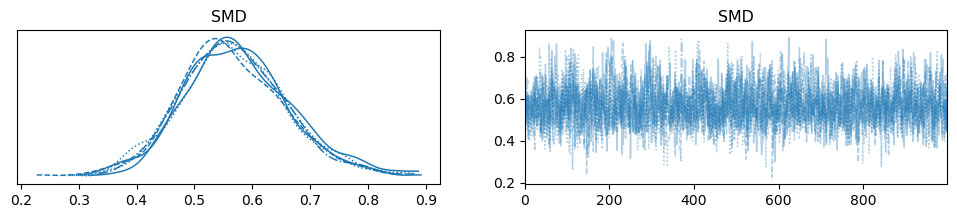

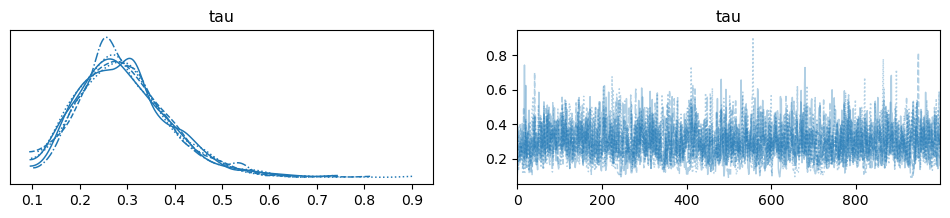

In [8]:
# plot using arviz the trace of MCMC samples.
az.plot_trace(trace, var_names="SMD");
az.plot_trace(trace, var_names="tau");

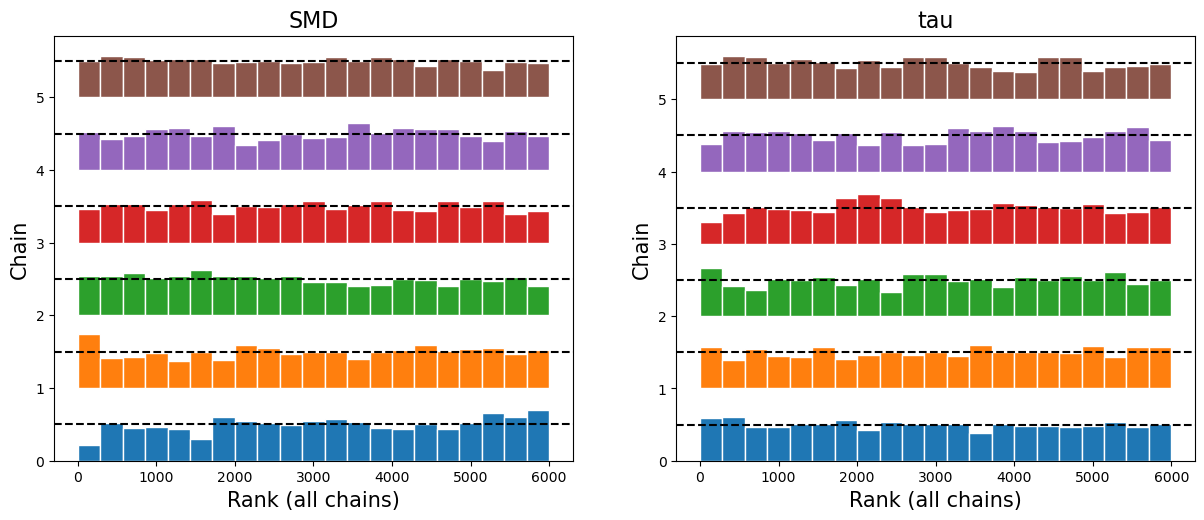

In [9]:
# Rank plot of MCMC chains.
az.plot_rank(trace, var_names=["SMD", "tau"]);

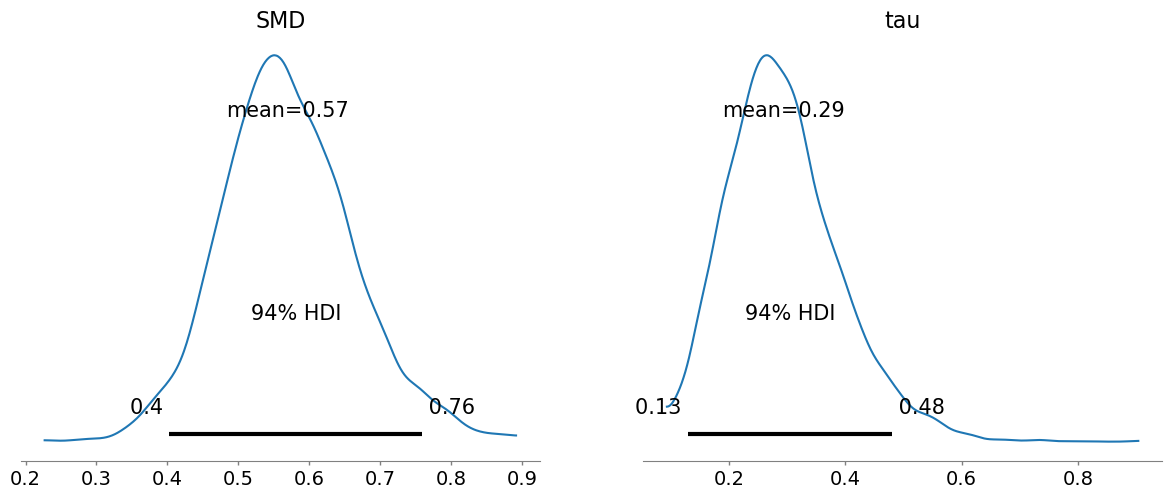

In [10]:
# plot posteriors
az.plot_posterior(trace,  var_names=["SMD", "tau"]);

## Posterior predictive check plot

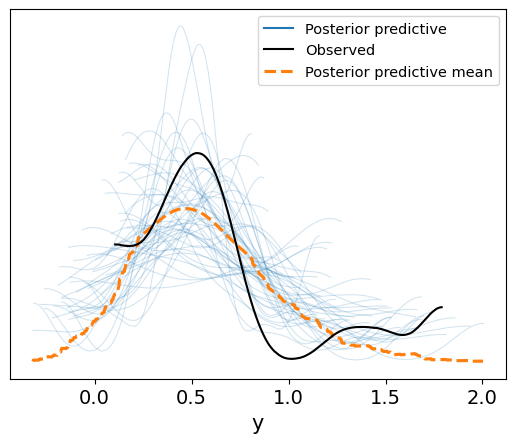

In [11]:
# To coincide with brms output in Harner et al. 
# smaller number of pp samples used than default.
az.plot_ppc(trace, num_pp_samples=50);

# Interpreting model results

The between study heterogenity has been estimated $\tau$ = .29, CrI [0.10, 0.49]. The fixed population effect $\mu$ = .57, CI [0.39, 0.76] as formulated within our model specification. Recalling that the dependent variable was an effect size measure the result of the analysis then suggest that psychotherpay interventions had a moderate effect because this is a Bayesian analysis we are not constrained to frame the results in terms of a Null hypotheis signifcane test. However, we would benefit from visualisations of the continous nature of the measures of effect estimated from the model to truely demonstrate this.  

## Posterior plots

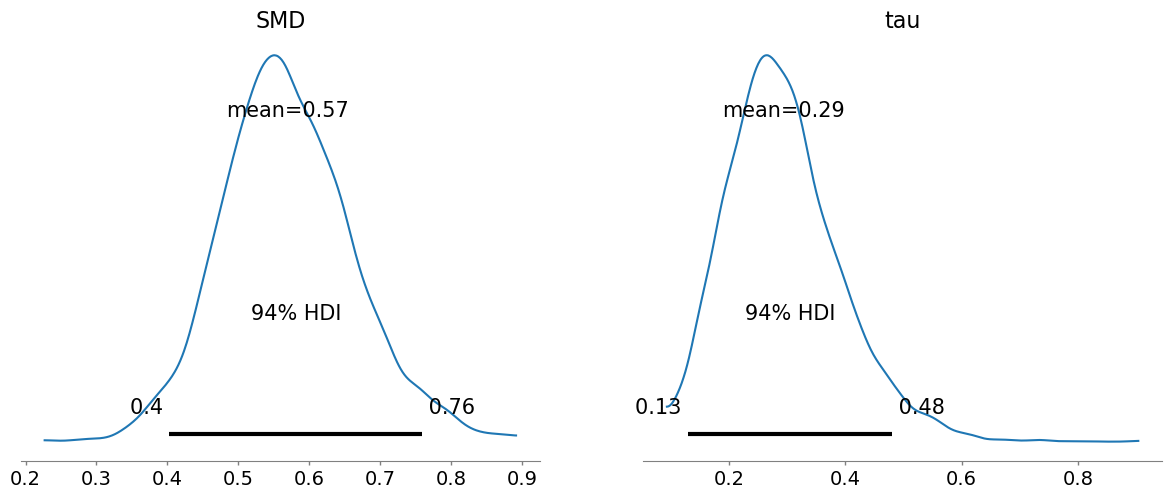

In [12]:
az.plot_posterior(trace,  var_names=["SMD", "tau"]);

# Empirical cumulative distribution function (ECDF) plot 

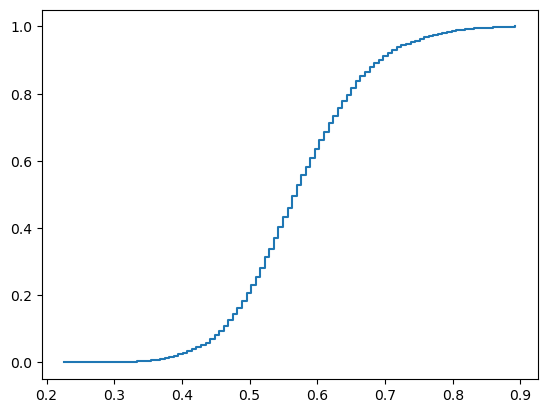

In [13]:
# Plot empirical cumulative distributing function.
az.plot_ecdf(trace.posterior.SMD);

As the posterior plots ECDF plot above shows There very low probabilty for values of effect sizes below ,4 

# Forest plot

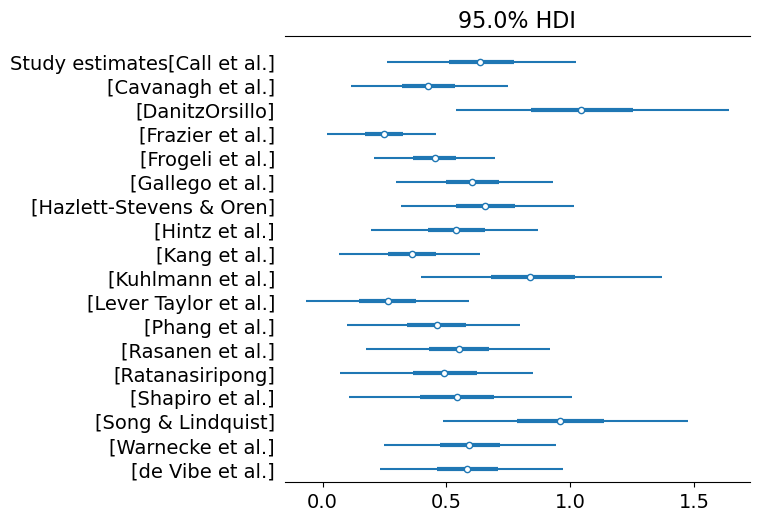

In [14]:
# Plot a arviz forest plot.
az.plot_forest(trace, var_names="Study estimates", combined= True, hdi_prob=.95);

# References
Glass, Gene V. 1976. “Primary, Secondary, and Meta-Analysis of Research.” Educational Researcher 5 (10): 3–8.

Harrer, M., Cuijpers, P., Furukawa, T.A., & Ebert, D.D. (2021). Doing Meta-Analysis with R: A Hands-On Guide. Boca Raton, FL and London: Chapmann & Hall/CRC Press. ISBN 978-0-367-61007-4.

Williams, D. R., Rast, P., & Bürkner, P. C. (2018). Bayesian meta-analysis with weakly informative prior distributions.